In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from torchvision.models import mobilenet_v3_small
import time

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
dataset = datasets.ImageFolder("~/Downloads/caltech256/256_objectcategories/256_ObjectCategories/", transform=transform)

In [5]:
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

classes = dataset.classes
classes = [re.sub(r"^\d+\.\s*", "", item) for item in classes]

In [6]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Baseline Model

In [7]:
model = mobilenet_v3_small(pretrained=True)

/Users/s.schroeder/anaconda3/envs/COGSFINAL/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/s.schroeder/anaconda3/envs/COGSFINAL/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
num_ftrs = model.classifier[-1].in_features
dropout_rate = 0.25
model.classifier[-1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, 257),  
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.train()
    train_losses = []
    val_losses = []  
    train_accuracies = []  
    val_accuracies = []  
    start_time = time.time() 
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            if i % 100 == 99: 
                print('[%d] loss: %.3f' %
                      (epoch + 1, running_loss / 100))
                train_losses.append(running_loss / 100)
                accuracy = correct_predictions / total_samples
                train_accuracies.append(accuracy)
                print('[%d] accuracy: %.3f' %
                      (epoch + 1, accuracy))
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0
        
        model.eval()  
        with torch.no_grad():
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
            val_loss /= len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print('[%d] Validation Loss: %.3f, Validation Accuracy: %.3f' % (epoch + 1, val_loss, val_accuracy))
            end_time = time.time() 
            elapsed_time = end_time - start_time 
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time


[1] loss: 2.698
[1] accuracy: 0.432
[1] Validation Loss: 1.645, Validation Accuracy: 0.603
[2] loss: 1.000
[2] accuracy: 0.743
[2] Validation Loss: 1.295, Validation Accuracy: 0.684
[3] loss: 0.511
[3] accuracy: 0.856
[3] Validation Loss: 1.217, Validation Accuracy: 0.703
[4] loss: 0.290
[4] accuracy: 0.913
[4] Validation Loss: 1.323, Validation Accuracy: 0.703
[5] loss: 0.191
[5] accuracy: 0.942
[5] Validation Loss: 1.449, Validation Accuracy: 0.687
[6] loss: 0.140
[6] accuracy: 0.957
[6] Validation Loss: 1.480, Validation Accuracy: 0.697
[7] loss: 0.132
[7] accuracy: 0.959
[7] Validation Loss: 1.437, Validation Accuracy: 0.703
[8] loss: 0.106
[8] accuracy: 0.968
[8] Validation Loss: 1.409, Validation Accuracy: 0.717
[9] loss: 0.094
[9] accuracy: 0.971
[9] Validation Loss: 1.501, Validation Accuracy: 0.706
[10] loss: 0.083
[10] accuracy: 0.976
[10] Validation Loss: 1.548, Validation Accuracy: 0.699


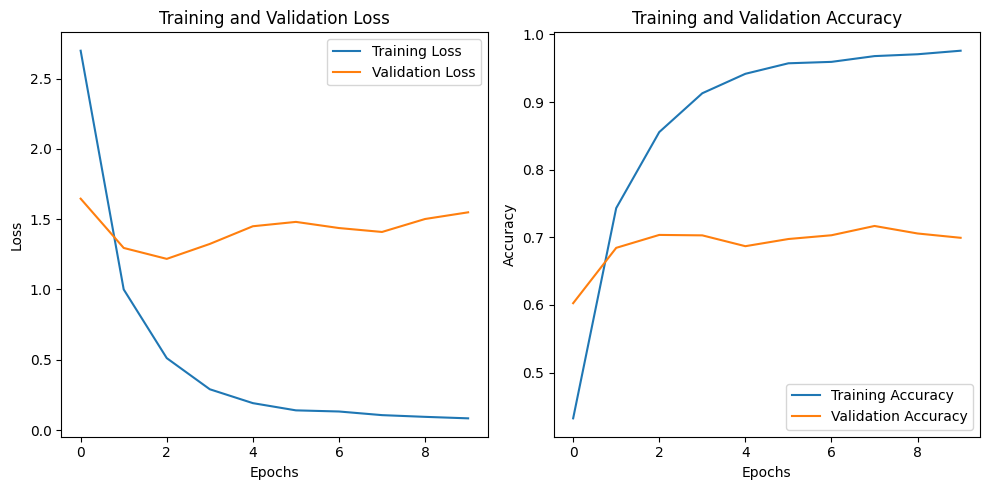

Elapsed time: 1035.762845993042 seconds


In [10]:
basetrain_losses, basetrain_accuracies, baseval_losses, baseval_accuracies, baseelapsed_time = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(basetrain_losses, label='Training Loss')
plt.plot(baseval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(basetrain_accuracies, label='Training Accuracy')
plt.plot(baseval_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Elapsed time: {baseelapsed_time} seconds")

# MobileNetV2

In [49]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [50]:
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

classes = dataset.classes
classes = [re.sub(r"^\d+\.\s*", "", item) for item in classes]

In [51]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
from torchvision.models import mobilenet_v2
model = mobilenet_v2(pretrained=True)

/Users/s.schroeder/anaconda3/envs/COGSFINAL/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
num_ftrs = model.classifier[-1].in_features
dropout_rate = 0.25
model.classifier[-1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, 257),  
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

[1] loss: 3.033
[1] accuracy: 0.371
[1] Validation Loss: 1.678, Validation Accuracy: 0.590
[2] loss: 5.438
[2] accuracy: 0.037
[2] Validation Loss: 5.477, Validation Accuracy: 0.023
[3] loss: 5.442
[3] accuracy: 0.029
[3] Validation Loss: 5.463, Validation Accuracy: 0.026
[4] loss: 5.436
[4] accuracy: 0.025
[4] Validation Loss: 5.463, Validation Accuracy: 0.024
[5] loss: 5.442
[5] accuracy: 0.026
[5] Validation Loss: 5.463, Validation Accuracy: 0.024
[6] loss: 5.436
[6] accuracy: 0.027
[6] Validation Loss: 5.457, Validation Accuracy: 0.026
[7] loss: 5.439
[7] accuracy: 0.028
[7] Validation Loss: 5.457, Validation Accuracy: 0.023
[8] loss: 5.440
[8] accuracy: 0.027
[8] Validation Loss: 5.462, Validation Accuracy: 0.024
[9] loss: 5.438
[9] accuracy: 0.027
[9] Validation Loss: 5.462, Validation Accuracy: 0.024
[10] loss: 5.438
[10] accuracy: 0.025
[10] Validation Loss: 5.459, Validation Accuracy: 0.023


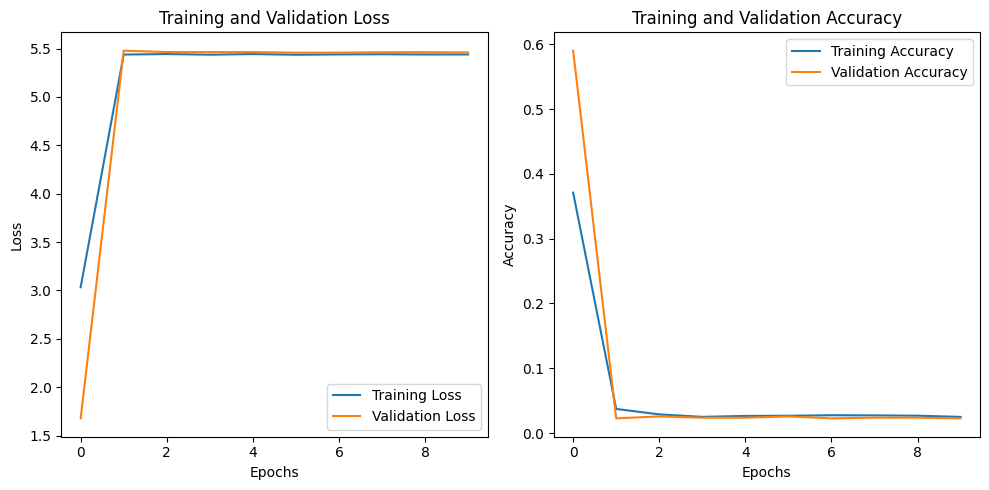

Elapsed time: 1709.450532913208 seconds


In [56]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.train()
    train_losses = []
    val_losses = []  
    train_accuracies = []  
    val_accuracies = []  
    start_time = time.time() 
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            if i % 100 == 99: 
                print('[%d] loss: %.3f' %
                      (epoch + 1, running_loss / 100))
                train_losses.append(running_loss / 100)
                accuracy = correct_predictions / total_samples
                train_accuracies.append(accuracy)
                print('[%d] accuracy: %.3f' %
                      (epoch + 1, accuracy))
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0
        
        model.eval()  
        with torch.no_grad():
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
            val_loss /= len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print('[%d] Validation Loss: %.3f, Validation Accuracy: %.3f' % (epoch + 1, val_loss, val_accuracy))
            end_time = time.time() 
            elapsed_time = end_time - start_time 
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time
v2train_losses, v2train_accuracies, v2val_losses, v2val_accuracies, v2elapsed_time = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(v2train_losses, label='Training Loss')
plt.plot(v2val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(v2train_accuracies, label='Training Accuracy')
plt.plot(v2val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Elapsed time: {v2elapsed_time} seconds")

# ELU Activation

In [11]:
model = mobilenet_v3_small(pretrained=True)

In [12]:
num_ftrs = model.classifier[-1].in_features
dropout_rate = 0.25
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, 257),
    nn.ELU()
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.train()
    train_losses = []
    val_losses = []  
    train_accuracies = []  
    val_accuracies = []  
    start_time = time.time() 
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            if i % 100 == 99: 
                print('[%d] loss: %.3f' %
                      (epoch + 1, running_loss / 100))
                train_losses.append(running_loss / 100)
                accuracy = correct_predictions / total_samples
                train_accuracies.append(accuracy)
                print('[%d] accuracy: %.3f' %
                      (epoch + 1, accuracy))
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0
        
        model.eval()  
        with torch.no_grad():
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
            val_loss /= len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print('[%d] Validation Loss: %.2f, Validation Accuracy: %.2f' % (epoch + 1, val_loss, val_accuracy))
            end_time = time.time() 
            elapsed_time = end_time - start_time 
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time

In [14]:
elutrain_losses, elutrain_accuracies, eluval_losses, eluval_accuracies, eluelapsed_time = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)


[1] loss: 2.981
[1] accuracy: 0.414
[1] Validation Loss: 1.79, Validation Accuracy: 0.59
[2] loss: 1.141
[2] accuracy: 0.725
[2] Validation Loss: 1.29, Validation Accuracy: 0.69
[3] loss: 0.576
[3] accuracy: 0.854
[3] Validation Loss: 1.23, Validation Accuracy: 0.70
[4] loss: 0.331
[4] accuracy: 0.912
[4] Validation Loss: 1.27, Validation Accuracy: 0.71
[5] loss: 0.233
[5] accuracy: 0.937
[5] Validation Loss: 1.43, Validation Accuracy: 0.70
[6] loss: 0.196
[6] accuracy: 0.947
[6] Validation Loss: 1.36, Validation Accuracy: 0.70
[7] loss: 0.151
[7] accuracy: 0.959
[7] Validation Loss: 1.36, Validation Accuracy: 0.70
[8] loss: 0.127
[8] accuracy: 0.965
[8] Validation Loss: 1.44, Validation Accuracy: 0.70
[9] loss: 0.108
[9] accuracy: 0.971
[9] Validation Loss: 1.55, Validation Accuracy: 0.70
[10] loss: 0.102
[10] accuracy: 0.972
[10] Validation Loss: 1.55, Validation Accuracy: 0.69


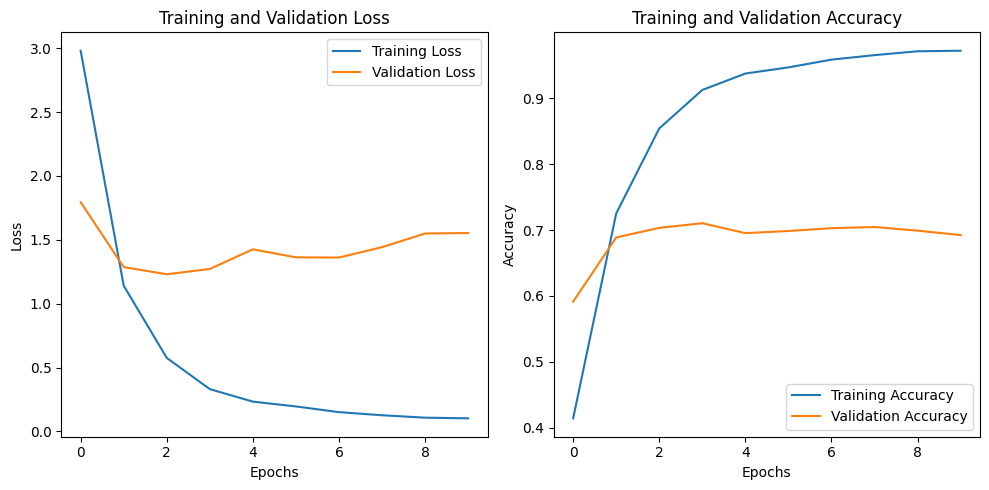

Elapsed time: 1036.3226120471954 seconds


In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(elutrain_losses, label='Training Loss')
plt.plot(eluval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(elutrain_accuracies, label='Training Accuracy')
plt.plot(eluval_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Elapsed time: {eluelapsed_time} seconds")

# GELU

In [16]:
model = mobilenet_v3_small(pretrained=True)

In [17]:
num_ftrs = model.classifier[-1].in_features
dropout_rate = 0.25
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, 257),
    nn.GELU()  
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.train()
    train_losses = []
    val_losses = []  
    train_accuracies = []  
    val_accuracies = []  
    start_time = time.time() 
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            if i % 100 == 99: 
                print('[%d] loss: %.3f' %
                      (epoch + 1, running_loss / 100))
                train_losses.append(running_loss / 100)
                accuracy = correct_predictions / total_samples
                train_accuracies.append(accuracy)
                print('[%d] accuracy: %.3f' %
                      (epoch + 1, accuracy))
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0
        
        model.eval()  
        with torch.no_grad():
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
            val_loss /= len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print('[%d] Validation Loss: %.3f, Validation Accuracy: %.3f' % (epoch + 1, val_loss, val_accuracy))
            end_time = time.time() 
            elapsed_time = end_time - start_time 
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time

[1] loss: 3.642
[1] accuracy: 0.349
[1] Validation Loss: 2.949, Validation Accuracy: 0.470
[2] loss: 2.426
[2] accuracy: 0.561
[2] Validation Loss: 2.653, Validation Accuracy: 0.518
[3] loss: 2.031
[3] accuracy: 0.640
[3] Validation Loss: 2.557, Validation Accuracy: 0.539
[4] loss: 1.831
[4] accuracy: 0.679
[4] Validation Loss: 2.609, Validation Accuracy: 0.543
[5] loss: 1.722
[5] accuracy: 0.696
[5] Validation Loss: 2.622, Validation Accuracy: 0.542
[6] loss: 1.686
[6] accuracy: 0.702
[6] Validation Loss: 2.662, Validation Accuracy: 0.536
[7] loss: 1.658
[7] accuracy: 0.707
[7] Validation Loss: 2.617, Validation Accuracy: 0.544
[8] loss: 1.623
[8] accuracy: 0.711
[8] Validation Loss: 2.706, Validation Accuracy: 0.530
[9] loss: 1.634
[9] accuracy: 0.709
[9] Validation Loss: 2.737, Validation Accuracy: 0.534
[10] loss: 1.593
[10] accuracy: 0.716
[10] Validation Loss: 2.770, Validation Accuracy: 0.530


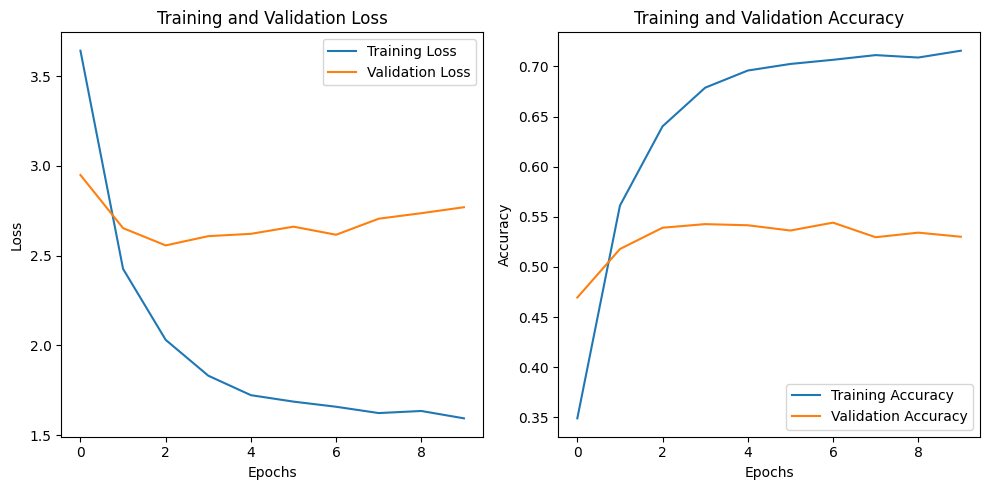

Elapsed time: 1046.6776881217957 seconds


In [19]:
gelutrain_losses, gelutrain_accuracies, geluval_losses, geluval_accuracies, geluelapsed_time = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(gelutrain_losses, label='Training Loss')
plt.plot(geluval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gelutrain_accuracies, label='Training Accuracy')
plt.plot(geluval_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Elapsed time: {geluelapsed_time} seconds")

Currently the main issue is low/stagnant validation accuracy and loss, will change dropout to see if this improves it

# Increase Dropout

In [20]:
model = mobilenet_v3_small(pretrained=True)

In [21]:
num_ftrs = model.classifier[-1].in_features
dropout_rate = 0.5
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, 257),
    nn.ELU()
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.train()
    train_losses = []
    val_losses = []  
    train_accuracies = []  
    val_accuracies = []  
    start_time = time.time() 
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            if i % 100 == 99: 
                print('[%d] loss: %.3f' %
                      (epoch + 1, running_loss / 100))
                train_losses.append(running_loss / 100)
                accuracy = correct_predictions / total_samples
                train_accuracies.append(accuracy)
                print('[%d] accuracy: %.3f' %
                      (epoch + 1, accuracy))
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0
        
        model.eval()  
        with torch.no_grad():
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
            val_loss /= len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print('[%d] Validation Loss: %.2f, Validation Accuracy: %.2f' % (epoch + 1, val_loss, val_accuracy))
            end_time = time.time() 
            elapsed_time = end_time - start_time 
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time

In [23]:
dptrain_losses, dptrain_accuracies, dpval_losses, dpval_accuracies, dpelapsed_time = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)


[1] loss: 3.437
[1] accuracy: 0.348
[1] Validation Loss: 2.12, Validation Accuracy: 0.55
[2] loss: 1.299
[2] accuracy: 0.692
[2] Validation Loss: 1.26, Validation Accuracy: 0.69
[3] loss: 0.675
[3] accuracy: 0.828
[3] Validation Loss: 1.21, Validation Accuracy: 0.70
[4] loss: 0.382
[4] accuracy: 0.900
[4] Validation Loss: 1.29, Validation Accuracy: 0.70
[5] loss: 0.273
[5] accuracy: 0.925
[5] Validation Loss: 1.39, Validation Accuracy: 0.69
[6] loss: 0.205
[6] accuracy: 0.942
[6] Validation Loss: 1.39, Validation Accuracy: 0.71
[7] loss: 0.146
[7] accuracy: 0.960
[7] Validation Loss: 1.45, Validation Accuracy: 0.70
[8] loss: 0.125
[8] accuracy: 0.966
[8] Validation Loss: 1.46, Validation Accuracy: 0.70
[9] loss: 0.110
[9] accuracy: 0.970
[9] Validation Loss: 1.45, Validation Accuracy: 0.71
[10] loss: 0.120
[10] accuracy: 0.966
[10] Validation Loss: 1.54, Validation Accuracy: 0.71


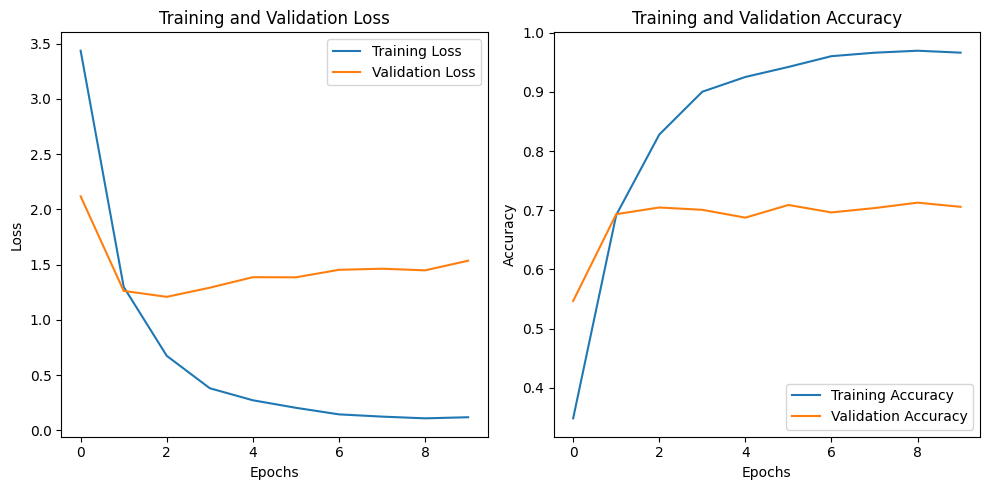

Elapsed time: 1044.9033510684967 seconds


In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(dptrain_losses, label='Training Loss')
plt.plot(dpval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dptrain_accuracies, label='Training Accuracy')
plt.plot(dpval_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Elapsed time: {dpelapsed_time} seconds")

# Add Regularization weight

In [25]:
model = mobilenet_v3_small(pretrained=True)

In [26]:
num_ftrs = model.classifier[-1].in_features
droupout_rate = 0.5
weight_decay = 1e-5 
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, 257),
    nn.ELU()
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

In [27]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.train()
    train_losses = []
    val_losses = []  
    train_accuracies = []  
    val_accuracies = []  
    start_time = time.time() 
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            if i % 100 == 99: 
                print('[%d] loss: %.3f' %
                      (epoch + 1, running_loss / 100))
                train_losses.append(running_loss / 100)
                accuracy = correct_predictions / total_samples
                train_accuracies.append(accuracy)
                print('[%d] accuracy: %.3f' %
                      (epoch + 1, accuracy))
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0
        
        model.eval()  
        with torch.no_grad():
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
            val_loss /= len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print('[%d] Validation Loss: %.2f, Validation Accuracy: %.2f' % (epoch + 1, val_loss, val_accuracy))
            end_time = time.time() 
            elapsed_time = end_time - start_time 
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time

In [29]:
wtrain_losses, wtrain_accuracies, wval_losses, wval_accuracies, welapsed_time = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)


[1] loss: 1.027
[1] accuracy: 0.746
[1] Validation Loss: 1.28, Validation Accuracy: 0.69
[2] loss: 0.640
[2] accuracy: 0.838
[2] Validation Loss: 1.26, Validation Accuracy: 0.70
[3] loss: 0.386
[3] accuracy: 0.897
[3] Validation Loss: 1.32, Validation Accuracy: 0.71
[4] loss: 0.239
[4] accuracy: 0.933
[4] Validation Loss: 1.35, Validation Accuracy: 0.71
[5] loss: 0.182
[5] accuracy: 0.952
[5] Validation Loss: 1.42, Validation Accuracy: 0.70
[6] loss: 0.157
[6] accuracy: 0.956
[6] Validation Loss: 1.39, Validation Accuracy: 0.71
[7] loss: 0.118
[7] accuracy: 0.968
[7] Validation Loss: 1.43, Validation Accuracy: 0.71
[8] loss: 0.113
[8] accuracy: 0.970
[8] Validation Loss: 1.57, Validation Accuracy: 0.69
[9] loss: 0.100
[9] accuracy: 0.972
[9] Validation Loss: 1.48, Validation Accuracy: 0.71
[10] loss: 0.083
[10] accuracy: 0.978
[10] Validation Loss: 1.47, Validation Accuracy: 0.71


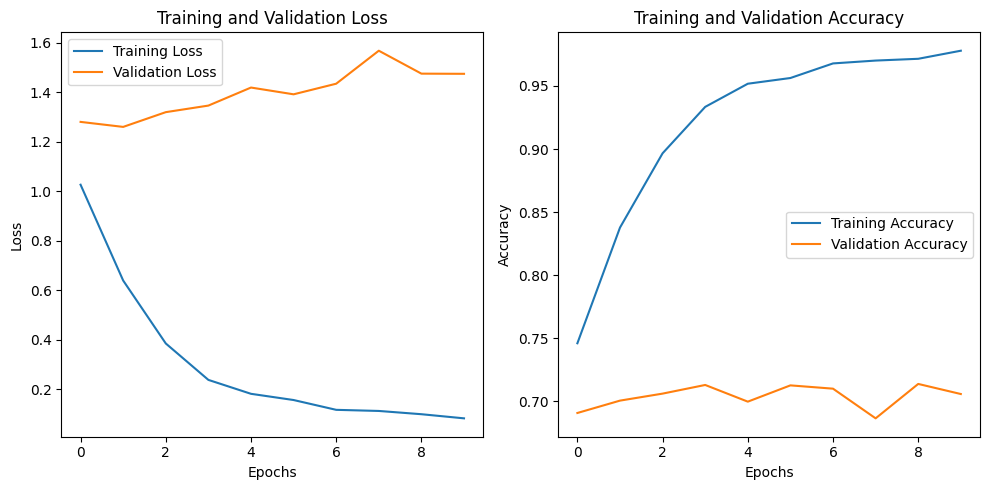

Elapsed time: 1064.165167093277 seconds


In [30]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(wtrain_losses, label='Training Loss')
plt.plot(wval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wtrain_accuracies, label='Training Accuracy')
plt.plot(wval_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Elapsed time: {welapsed_time} seconds")

Model Still showing signs of overfitting, will make changes to pre-processing instead including remove normalization as well as attempt to make changes to layers. Edit: Will be final model due to increased validation accuracy and lower/consistent loss

# Freeze Convolution Layers, but return normalized data

In [64]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),       
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])               
])

In [65]:
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

classes = dataset.classes
classes = [re.sub(r"^\d+\.\s*", "", item) for item in classes]

In [66]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [67]:
model = mobilenet_v3_small(pretrained=True)

In [68]:
num_ftrs = model.classifier[-1].in_features
dropout_rate = 0.25
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(num_ftrs, 257), 
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for param in model.features.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [69]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.train()
    train_losses = []
    val_losses = []  
    train_accuracies = []  
    val_accuracies = []  
    start_time = time.time() 
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            if i % 100 == 99: 
                print('[%d] loss: %.3f' %
                      (epoch + 1, running_loss / 100))
                train_losses.append(running_loss / 100)
                accuracy = correct_predictions / total_samples
                train_accuracies.append(accuracy)
                print('[%d] accuracy: %.3f' %
                      (epoch + 1, accuracy))
                running_loss = 0.0
                correct_predictions = 0
                total_samples = 0
        
        model.eval()  
        with torch.no_grad():
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
            val_loss /= len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print('[%d] Validation Loss: %.2f, Validation Accuracy: %.2f' % (epoch + 1, val_loss, val_accuracy))
            end_time = time.time() 
            elapsed_time = end_time - start_time 
    return train_losses, train_accuracies, val_losses, val_accuracies, elapsed_time

In [70]:
cvtrain_losses, cvtrain_accuracies, cvval_losses, cvval_accuracies, cvelapsed_time = train(model, train_loader, val_loader, criterion, optimizer, epochs=20)


[1] loss: 5.178
[1] accuracy: 0.079
[1] Validation Loss: 4.03, Validation Accuracy: 0.26
[2] loss: 3.208
[2] accuracy: 0.454
[2] Validation Loss: 2.17, Validation Accuracy: 0.62
[3] loss: 1.691
[3] accuracy: 0.698
[3] Validation Loss: 1.54, Validation Accuracy: 0.69
[4] loss: 1.221
[4] accuracy: 0.755
[4] Validation Loss: 1.31, Validation Accuracy: 0.72
[5] loss: 1.013
[5] accuracy: 0.785
[5] Validation Loss: 1.21, Validation Accuracy: 0.73
[6] loss: 0.874
[6] accuracy: 0.810
[6] Validation Loss: 1.15, Validation Accuracy: 0.74
[7] loss: 0.781
[7] accuracy: 0.828
[7] Validation Loss: 1.10, Validation Accuracy: 0.74
[8] loss: 0.710
[8] accuracy: 0.841
[8] Validation Loss: 1.06, Validation Accuracy: 0.75
[9] loss: 0.654
[9] accuracy: 0.856
[9] Validation Loss: 1.04, Validation Accuracy: 0.75
[10] loss: 0.609
[10] accuracy: 0.866
[10] Validation Loss: 1.02, Validation Accuracy: 0.76
[11] loss: 0.556
[11] accuracy: 0.878
[11] Validation Loss: 1.01, Validation Accuracy: 0.76
[12] loss: 0.53

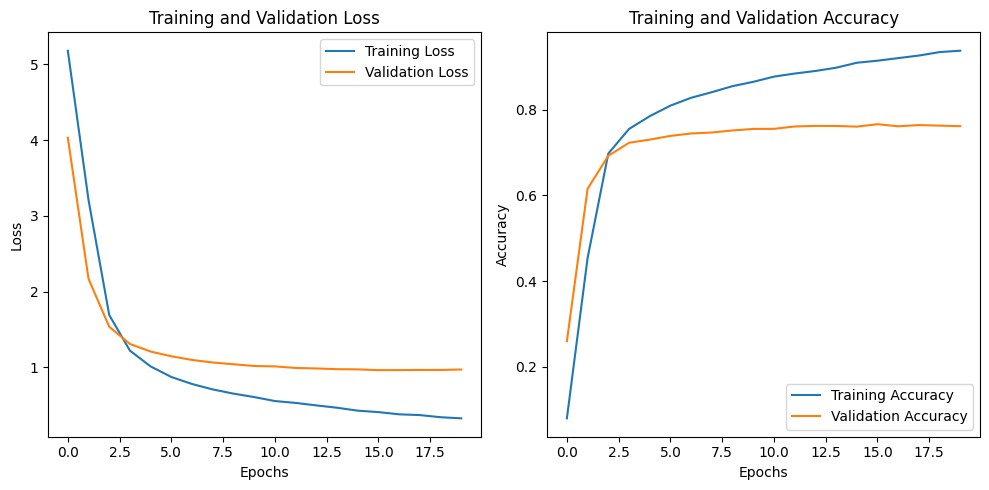

Elapsed time: 1064.165167093277 seconds


In [71]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cvtrain_losses, label='Training Loss')
plt.plot(cvval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cvtrain_accuracies, label='Training Accuracy')
plt.plot(cvval_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(f"Elapsed time: {welapsed_time} seconds")

# Testing Set

In [72]:
def test(model, test_loader, criterion):
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        model.to(mps_device)
    else:
        mps_device = torch.device("cpu")
    model.eval()  
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        test_loss /= len(test_loader)
        test_accuracy = correct_predictions / total_samples
    return test_loss, test_accuracy

final_train_loss, final_train_accuracy = cvtrain_losses[-1], cvtrain_accuracies[-1]
final_val_loss, final_val_accuracy = cvval_losses[-1], cvval_accuracies[-1]

print(f"Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_accuracy:.4f}")

test_loss, test_accuracy = test(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Final Training Loss: 0.3283, Final Training Accuracy: 0.9384
Final Validation Loss: 0.9724, Final Validation Accuracy: 0.7620
Test Loss: 0.9324, Test Accuracy: 0.7648


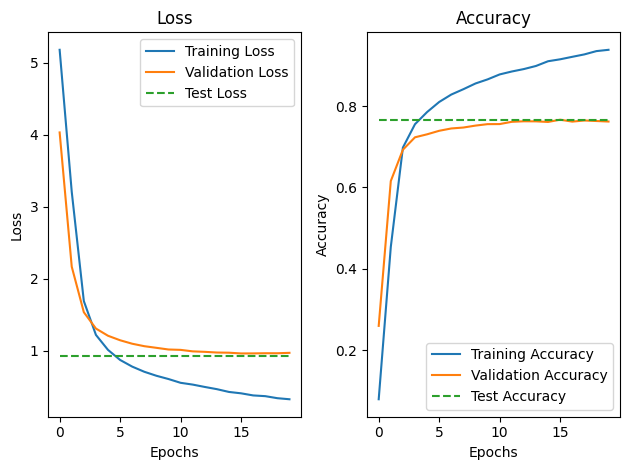

In [73]:
plt.subplot(1, 2, 1)
plt.plot(cvtrain_losses, label='Training Loss')
plt.plot(cvval_losses, label='Validation Loss')
plt.plot(range(len(cvval_losses)), [test_loss] * len(cvval_losses), label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cvtrain_accuracies, label='Training Accuracy')
plt.plot(cvval_accuracies, label='Validation Accuracy')
plt.plot(range(len(cvval_accuracies)), [test_accuracy] * len(cvval_accuracies), label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()